## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

%matplotlib inline

In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

100%|██████████| 170M/170M [00:02<00:00, 58.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([3, 32, 32])


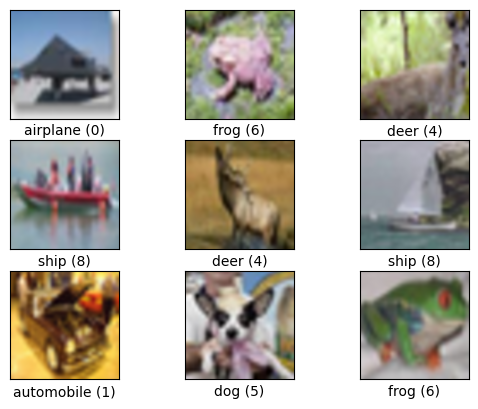

In [4]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Define the transform for training (and data augmentation)

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        print(images[0].shape)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

trainloader, valloader = get_train_valid_loader()

# Convolutional Neural Network Architecture

Please first review the CNN lecture and problem statement pdf to understand the overall architecture of a CNN and how each dimension evolves after each layer, we'll take as example the first and famous CNN LeNet5 :
<figure align="center">
  <img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/10/image-17.png" alt="LeNet5 Architecture" width="600">
  <figcaption>Image credit: <a href="https://en.wikipedia.org">Wikipedia</a></figcaption>
</figure>

# **Theory - Part 1 (20%)**

Please answer the following questions to assess your understanding of what happens during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.

## 1. First Layer Convolution

If we consider the input of LeNet5 to be CIFAR-10, what would be the shape of the parameters of the first convolutional layer (stride = 1)?

- **A.** `torch.Size([6, 1, 5, 5])`
- **B.** `torch.Size([6, 3, 3, 3])`
- **C.** `torch.Size([6, 1, 5, 5])`
- **D.** `torch.Size([6, 3, 5, 5])`

## Ans1: D

## 2. Subsampling Window

What is the shape of the subsampling window (stride = 2) for the second layer (between C1 and C2), and does this shape remain invariant regardless of the subsampling method (e.g., Avg pooling or Max pooling)?

- **A.** `2x2, yes it does`
- **B.** `3x3, no it doesn't`
- **C.** `2x2, no it doesn't`
- **D.** `yes, it does`




```
# This is formatted as code
```

## Ans2: A

## 3. Backpropagation for Convolutional Filters

Do the filters in the convolutional layers also benefit from backpropagation?

## Ans3: Yes, the filters must be learned.

## 4. Role of the Fully-Connected Layer

Explain in your own words why it is necessary to have a fully-connected layer in the architecture.


## Ans4: A filter (after convolution with the input volume) will produce a 2 * 2 activation map. Low level filters (in the first layers) might be learned to detect edges while higher level filters (in the last layers) might detect whole objects or parts of the image like a wheel. In the example of a truck, the activation 2 * 2 map produced by the "high level wheel filter" will have high values where the wheels of the truck are. However, to translate this information that this image contained wheels into class scores, we need FC layers in the end to map the final output volume (depth * (2 * 2 activation maps)) to the final class scores based on the responses to the different filters. So, in the example of the truck, if the activation map for the "wheel filter" has peaks of high values, then the FC layers will learn to augment the probabilities for the truck class. All this "mapping logic" is done/learned by the FC layers.

# **Coding(60%)**

## Build your own Convolutional Neural Network Architecture

## Different ways to improve the accuracy of your network :
- Change the number of convolutions and layers (you can take inspiration from internet as you as you cite the architecture)
- Change the optmizer / its hyperparameters
- Add new types of layers
- Do some data augmentation in the get_train_valid_loader function (flipped, cropped, uncentered images) cf. https://pytorch.org/vision/stable/transforms.html


In [11]:
# Inspired by the TinyCNN architecture, source: https://github.com/soyflourbread/cifar10-tiny
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)


In [19]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(net.parameters(), lr=0.001)


epochs = 3
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                probs = net.predict(images)
                preds = torch.argmax(probs, dim=1)
                accuracy += torch.sum(preds == labels).item() / len(labels)
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

<ipython-input-11-bd4eccf27d2b>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits)


Epoch: 1/3.. Loss: 0.7689.. Test accuracy: 0.6689.. 0.1504 s/batch
Epoch: 1/3.. Loss: 0.7497.. Test accuracy: 0.6480.. 0.1598 s/batch
Epoch: 1/3.. Loss: 0.8108.. Test accuracy: 0.6826.. 0.1369 s/batch
Epoch: 1/3.. Loss: 0.7461.. Test accuracy: 0.6898.. 0.1259 s/batch
Epoch: 1/3.. Loss: 0.8099.. Test accuracy: 0.6443.. 0.1261 s/batch
Epoch: 1/3.. Loss: 0.7677.. Test accuracy: 0.6635.. 0.1906 s/batch
Epoch: 1/3.. Loss: 0.8071.. Test accuracy: 0.6625.. 0.1279 s/batch
Epoch: 1/3.. Loss: 0.8528.. Test accuracy: 0.6623.. 0.1268 s/batch
Epoch: 1/3.. Loss: 0.7360.. Test accuracy: 0.6705.. 0.1827 s/batch
Epoch: 1/3.. Loss: 0.7625.. Test accuracy: 0.6697.. 0.1264 s/batch
Epoch: 1/3.. Loss: 0.7588.. Test accuracy: 0.6773.. 0.1252 s/batch
Epoch: 1/3.. Loss: 0.8113.. Test accuracy: 0.6811.. 0.1758 s/batch
Epoch: 1/3.. Loss: 0.7683.. Test accuracy: 0.6654.. 0.1530 s/batch
Epoch: 1/3.. Loss: 0.8408.. Test accuracy: 0.6697.. 0.1253 s/batch
Epoch: 1/3.. Loss: 0.8142.. Test accuracy: 0.6525.. 0.1260 s/b

Save best trained model.

In [20]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
torch.save(net.state_dict(), 'drive/MyDrive/Colab Notebooks/CNN_cifar_10.ckpt')

In [36]:
## Load model
checkpoint = torch.load("drive/MyDrive/Colab Notebooks/CNN_cifar_10.ckpt")
net.load_state_dict(checkpoint)

<All keys matched successfully>

# Some visualisations and Interpretation questions
This code allows us to look at the filters of the first layer of convolution :

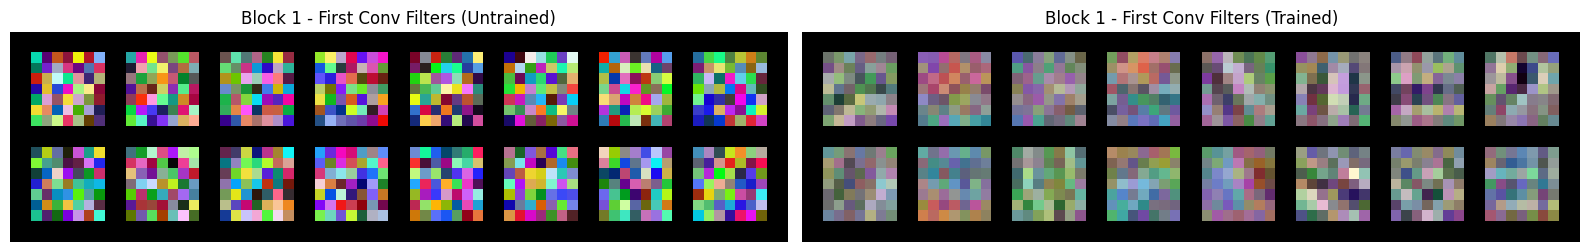

In [24]:
def visualize_filters(layer, title='Filters'):
    filters = layer.weight.data.clone().cpu()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    grid = vutils.make_grid(filters, nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = ConvNet() # Untrained model

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Untrained filters ---
filters_untrained = model.conv1.weight.data.clone().cpu()
filters_untrained = (filters_untrained - filters_untrained.min()) / (filters_untrained.max() - filters_untrained.min())
grid_untrained = vutils.make_grid(filters_untrained, nrow=8, padding=2)
axes[0].imshow(grid_untrained.permute(1, 2, 0))
axes[0].set_title("Block 1 - First Conv Filters (Untrained)")
axes[0].axis("off")

# --- Trained filters ---
filters_trained = net.conv1.weight.data.clone().cpu()
filters_trained = (filters_trained - filters_trained.min()) / (filters_trained.max() - filters_trained.min())
grid_trained = vutils.make_grid(filters_trained, nrow=8, padding=2)
axes[1].imshow(grid_trained.permute(1, 2, 0))
axes[1].set_title("Block 1 - First Conv Filters (Trained)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#### What do you notice about the filters after the training ? Try to fin an interpretation about it.
The filters after training detect low level features like edges. It's still a bit unclear here, but we can detect vague "diagonals" in a few of the filters, that detect diagonal edges.

### Activation maps
This code snippet uses a forward hook to capture the output of the first convolutional layer of a CNN when a sample image is passed through it. The resulting activation maps show how each filter in the layer responds to different regions or features in the image.

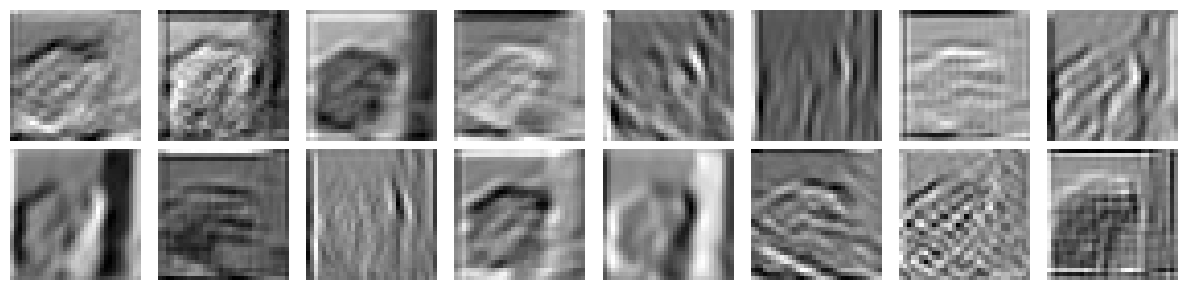

In [37]:
def get_activation(model, layer, x):
    activation = {}
    def hook_fn(module, input, output):
        activation['output'] = output.detach().cpu()
    hook = layer.register_forward_hook(hook_fn)
    model(x)
    hook.remove()
    return activation['output']

data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_img = sample_images[3].unsqueeze(0)

# Get the feature maps after the first convolution (for example)
activation = get_activation(net, net.conv1, sample_img)

# Visualize a few feature maps in RGB:
def plot_feature_maps(feature_maps, n_cols=8):
    n_features = feature_maps.shape[1]
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        # Extract the i-th feature map from the first (and only) sample in the batch
        act = feature_maps[0, i, :, :]
        # Normalize the activation map to [0, 1]
        act_norm = (act - act.min()) / (act.max() - act.min() + 1e-8)
        # Repeat the single channel 3 times to form an RGB image
        act_rgb = act_norm.unsqueeze(0).repeat(3, 1, 1)
        plt.imshow(act_rgb.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_maps(activation, n_cols=8)

# Play with the index of the chosen sample to notice more patterns and answer the question


# **Theory - Part 2 (20%)**

Please answer the following questions based on your experience/observation during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.


## 5. Feature Detection
What specific features do you observe in these activation maps? Do some maps clearly highlight edges, contours, or textures? How might these features relate to the overall structure of the sample (e.g., the outline of a horse)?

## Ans5:
Some features extracted are edges and texture features. We recognize edge filters by their activation maps that contain boundaries. The edge filters help the CNN determine the global shape of the object. On the other hand, texture filters produce activation maps that contain high intensity (white) "blobs", that might detect some fur on an animal or others. Then, the deeper filters that receive as input these first activation maps will be learned to detect combinations of these activations, i.e. combinations of edge or texture responses to eventually detect more complex shapes or even objects. We can also understand it more pragmatically by the fact that the deeper a filter is in the network, the larger the region of the input image it "sees", i.e. the greater the receptive field, since it's operating on activation maps that already represent more complex features.


## 6. Effect of Training
Consider how the activations might change after training versus an untrained (random) network. What does this tell you about the learning process?

## Ans6:
Initially, the activation maps for the untrained network are very noisy, meaning the filters don't detect any particular feature and therefore the network does not make distinctions between different regions of the input image. However, after the training, the activation maps produced seem to respond to meaningful parts of the image in a structured way and in different spatial regions of the input image, as detailed above. So, it tells us that the learning process refines the filters to extract more meaningful filters in an organized way and the network learns to focus on relevant parts of the image, suppresing irrelevant information.